# Data Exploration

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow.parquet as pq
import gc
import pywt
from statsmodels.robust import mad
import scipy
from scipy import signal
from scipy.signal import butter
import sys
import time 

plt.style.use('ggplot')
data_dir = '../Input'
report_dir = '../Report'

sys.path.append('../')

from Source.feature_extraction import *
from Source.signal_denoising import *

### Data Description

In [3]:
metadata_train = pd.read_csv(data_dir + '/metadata_train.csv', sep = ",")
metadata_train.head()
print('Number of signals: {}'.format(metadata_train.shape[0]) )


Number of signals: 8712


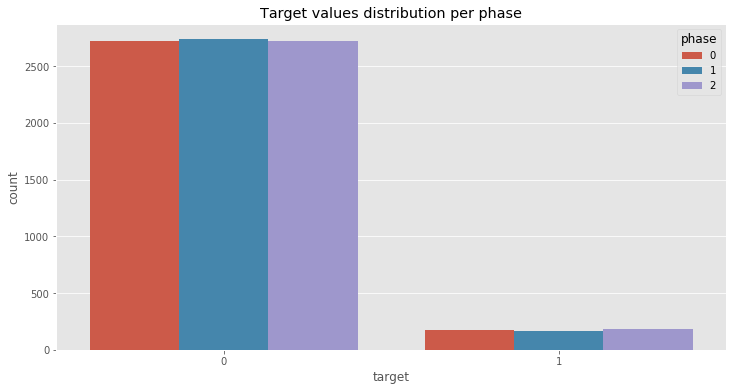

In [20]:
fig = plt.figure(figsize = (12,6))
sns.countplot(data=metadata_train, x = 'target', hue='phase')
plt.title('Target values distribution per phase')

plt.savefig(report_dir + '/train_data_dist.png')

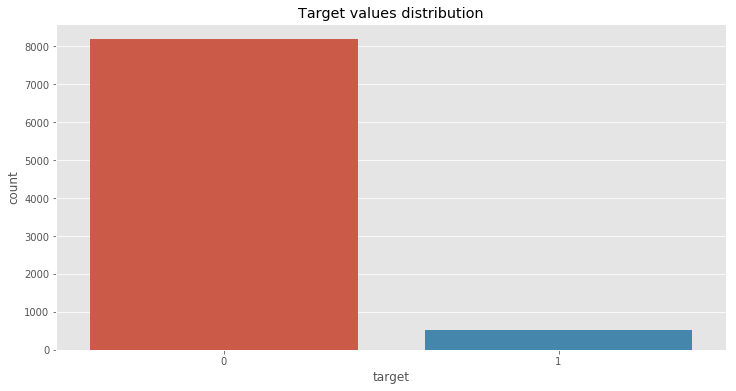

In [21]:
fig = plt.figure(figsize = (12,6))
sns.countplot(data=metadata_train, x = 'target')
plt.title('Target values distribution')

plt.savefig(report_dir + '/train_data_dist_targets.png')

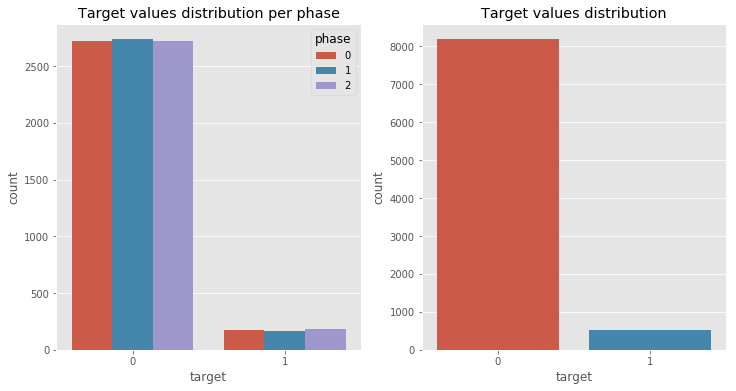

In [50]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

sns.countplot(data=metadata_train, x = 'target', hue='phase', ax = ax[0])
ax[0].set_title('Target values distribution per phase')

sns.countplot(data=metadata_train, x = 'target', ax = ax[1])
ax[1].set_title('Target values distribution')

plt.savefig(report_dir + '/train_data_dist_twosided.png')

In [22]:
metadata_train.target.value_counts() / metadata_train.shape[0]

0    0.939738
1    0.060262
Name: target, dtype: float64

In [4]:
SAMPLING_FREQ = 800000 / 0.02  # 800,000 data points taken over 20 ms

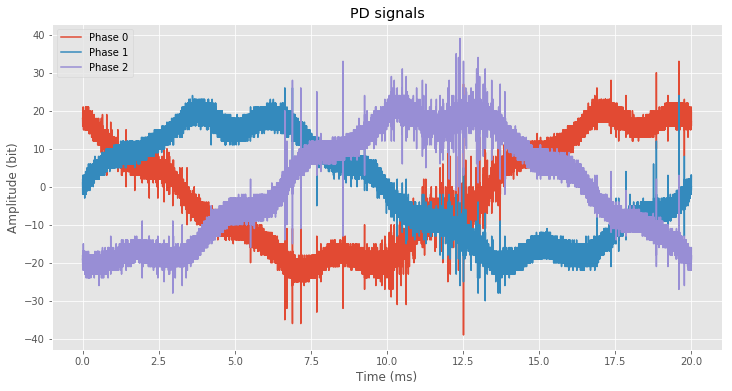

In [19]:
subset_train = pq.read_pandas(data_dir + '/train.parquet', columns=[str(i) for i in range(0,3)]).to_pandas()


plt.figure(figsize=(12, 6))
time = subset_train.index * 1000 / SAMPLING_FREQ #s
plt.plot(time,subset_train['0'], label='Phase 0')
plt.plot(time,subset_train['1'], label='Phase 1')
plt.plot(time,subset_train['2'], label='Phase 2')
plt.ylabel('Amplitude (bit)')
plt.xlabel('Time (ms)')
plt.title('PD signals')
plt.legend()
plt.savefig(report_dir + '/signal_phase_example.png')


### Signal Filtering

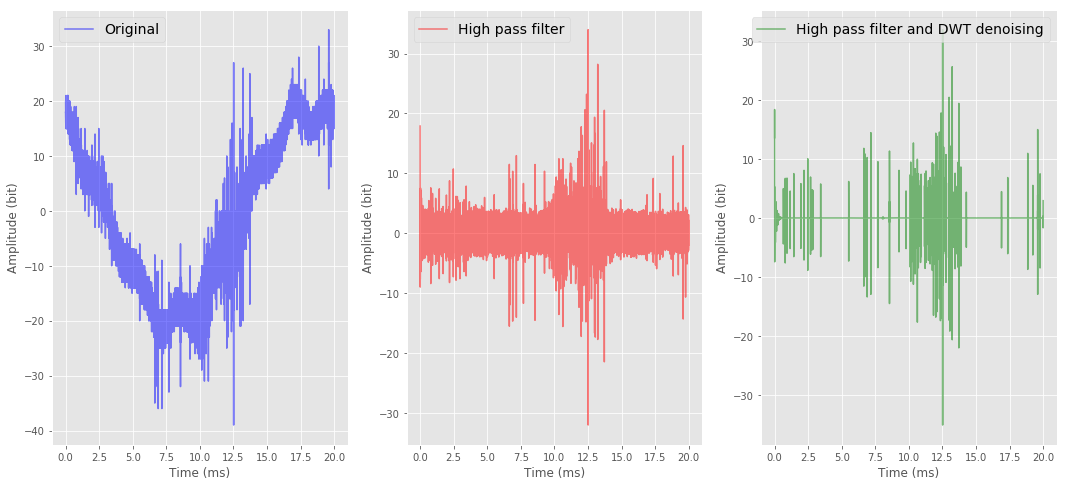

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 8))
time = subset_train.index * 1000 / SAMPLING_FREQ #s

# FIG 1
ax[0].plot(time, subset_train['0'],'b', alpha=0.5)
ax[0].legend(['Original'], fontsize=14)
ax[0].set_ylabel('Amplitude (bit)')
ax[0].set_xlabel('Time (ms)')

ax[1].plot(time, high_pass_filter(subset_train['0'], low_cutoff = 10000), 'r', alpha=0.5)
ax[1].legend(['High pass filter'], fontsize=14)
ax[1].set_ylabel('Amplitude (bit)')
ax[1].set_xlabel('Time (ms)')

ax[2].plot(time, denoise_signal(subset_train['0'], low_freq = 10000), 'g', alpha=0.5)
ax[2].legend(['High pass filter and DWT denoising'], fontsize=14)
ax[2].set_ylabel('Amplitude (bit)')
ax[2].set_xlabel('Time (ms)')

"""
# FIG 1
ax[0,0].plot(subset_train['0'], alpha=0.5)
ax[0,0].legend(['Original'], fontsize=24)

ax[0,1].plot(x_hp, 'r', alpha=0.5)
ax[0,1].legend(['High pass filter'], fontsize=24)

ax[0,2].plot(x_dn, 'g', alpha=0.5)
ax[0,2].legend(['High pass filter and DWT denoising'], fontsize=24)


# FIG 2
ax[1,0].plot(subset_train['1'], alpha=0.5)
ax[1,0].legend(['Original'], fontsize=24)

ax[1,1].plot(x_hp, 'r', alpha=0.5)
ax[1,1].legend(['High pass filter'], fontsize=24)

ax[1,2].plot(x_dn, 'g', alpha=0.5)
ax[1,2].legend(['HP filter and denoising'], fontsize=24)


# FIG 3
ax[2,0].plot(subset_train['2'], alpha=0.5)
ax[2,0].legend(['Original'], fontsize=24)

ax[2,1].plot(x_hp, 'r', alpha=0.5)
ax[2,1].legend(['HP filter'], fontsize=24)

ax[2,2].plot(x_dn, 'g', alpha=0.5)
ax[2,2].legend(['HP filter and denoising'], fontsize=24)

"""
plt.savefig(report_dir + '/signal_phase_denoised.png')



### Feature Extraction

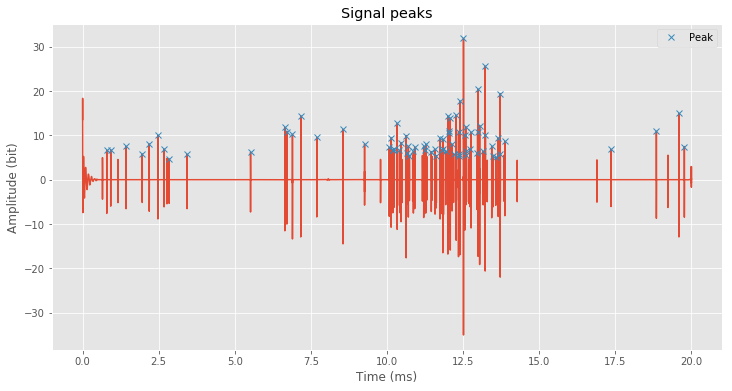

In [23]:
x_dn = denoise_signal(subset_train['0'], low_freq = 10000)   
peaks, properties = signal.find_peaks(x_dn, prominence = 10, distance = 50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
time = subset_train.index * 1000 / SAMPLING_FREQ #s

ax.plot(time, x_dn)
ax.plot(time[peaks], x_dn[peaks], "x", label='Peak')
ax.set_ylabel('Amplitude (bit)')
ax.set_xlabel('Time (ms)')
ax.set_title('Signal peaks')
plt.legend()
plt.savefig(report_dir + '/signal_peaks.png')


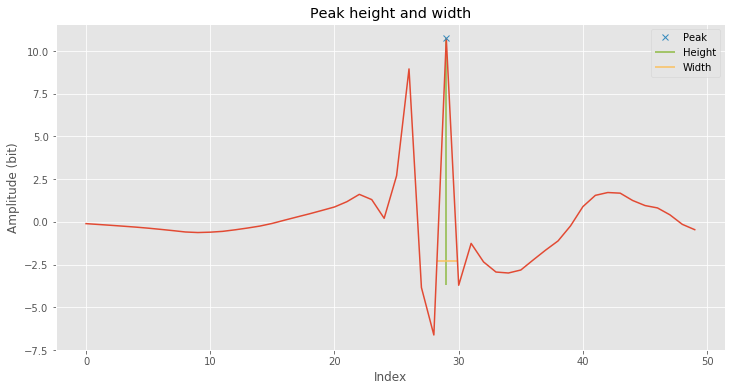

In [24]:
time = subset_train.index * 1000 / SAMPLING_FREQ #s
r = range(519050,519100)

x_dn_ss = x_dn[r]
time_ss = time[r]
peaks, properties = signal.find_peaks(x_dn_ss, prominence = 10, distance = 50)
widths = signal.peak_widths(x_dn_ss, peaks, rel_height=0.9)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
ax.plot(x_dn_ss)
ax.plot(peaks, x_dn_ss[peaks], "x", label='Peak')
ax.set_ylabel('Amplitude (bit)')
ax.set_xlabel('Index')
ax.vlines(x=peaks, ymin=x_dn_ss[peaks] - properties["prominences"], ymax = x_dn_ss[peaks], color = "C5", label='Height')
ax.hlines(*widths[1:], color = "C4", label='Width')
plt.legend()
ax.set_title('Peak height and width')
plt.savefig(report_dir + '/signal_peak_zoom.png')

In [44]:
id_signal_normal = metadata_train[metadata_train.target == 0]['signal_id'].iloc[3]
id_signal_fault = metadata_train[metadata_train.target == 1]['signal_id'].iloc[3]

signal_raw_normal = pq.read_pandas(data_dir + '/train.parquet', columns = [str(id_signal_normal)]).to_pandas().squeeze()
signal_raw_fault = pq.read_pandas(data_dir + '/train.parquet', columns = [str(id_signal_fault)]).to_pandas().squeeze()

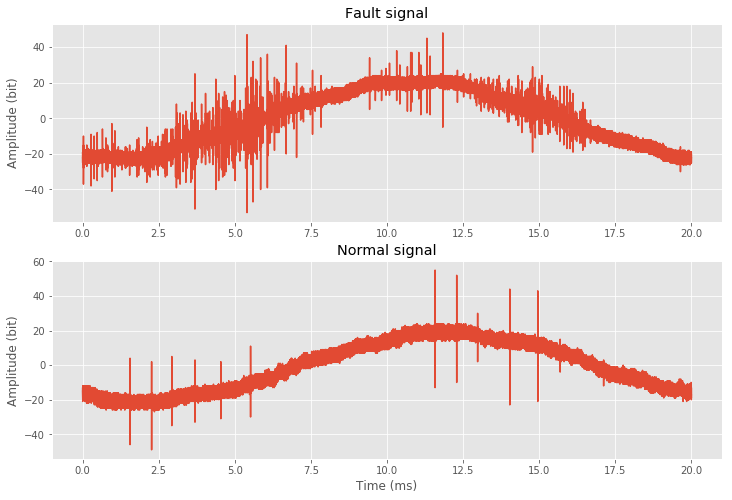

In [45]:
fig, ax = plt.subplots(2, 1, figsize = (12,8))
time = signal_raw_fault.index * 1000 / SAMPLING_FREQ #s

ax[0].plot(time, signal_raw_fault)
ax[0].set_title('Fault signal')
ax[0].set_ylabel('Amplitude (bit)')

ax[1].plot(time, signal_raw_normal)
ax[1].set_title('Normal signal')
ax[1].set_xlabel('Time (ms)')
ax[1].set_ylabel('Amplitude (bit)')

plt.savefig(report_dir + '/signal_fault_normal_raw.png')

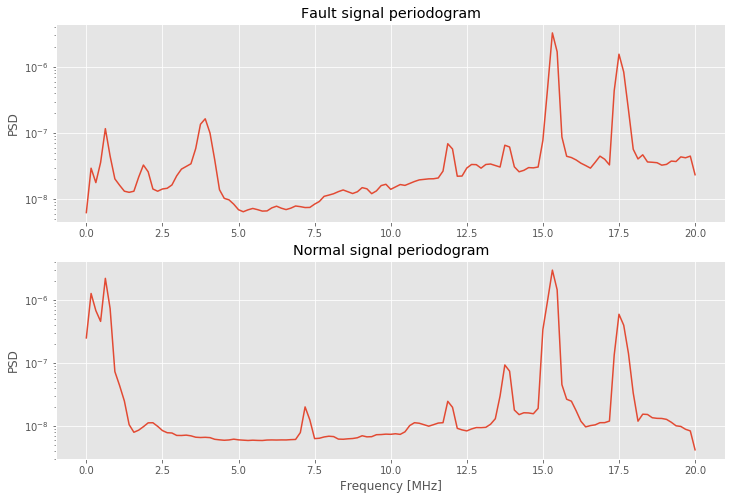

In [33]:

f, Pxx_den = signal.welch(signal_raw_fault, SAMPLING_FREQ)
f2, Pxx_den2 = signal.welch(signal_raw_normal, SAMPLING_FREQ)

fig, ax = plt.subplots(2, 1, figsize = (12,8))

ax[0].semilogy(f/1000000, Pxx_den)
ax[0].set_xlabel('')
ax[0].set_ylabel('PSD')
ax[0].set_title('Fault signal periodogram')

ax[1].semilogy(f2/1000000, Pxx_den2)
ax[1].set_title('Normal signal periodogram')
ax[1].set_xlabel('Frequency [MHz]')
ax[1].set_ylabel('PSD')


plt.savefig(report_dir + '/signal_fault_normal_psd_raw.png')

In [34]:
signal_fault_dn = denoise_signal(signal_raw_fault, wavelet='db4', level=2, low_freq=10000, mode='zero')
signal_normal_dn = denoise_signal(signal_raw_normal, wavelet='db4', level=2, low_freq=10000, mode='zero')

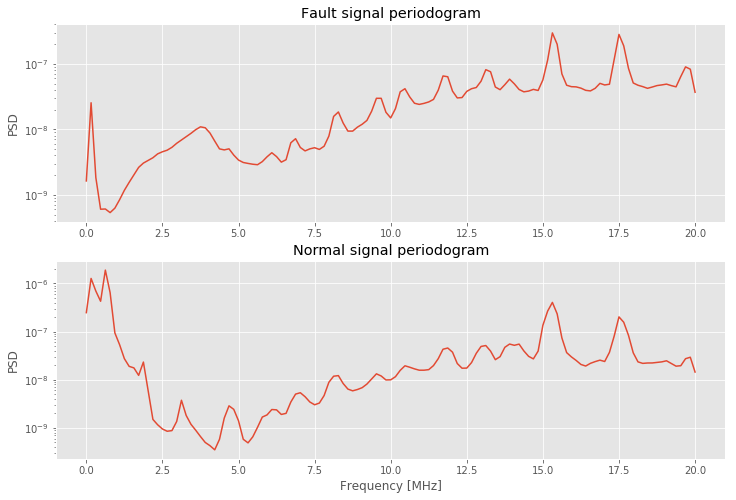

In [35]:
f, Pxx_den = signal.welch(signal_fault_dn, SAMPLING_FREQ)
f2, Pxx_den2 = signal.welch(signal_normal_dn, SAMPLING_FREQ)

fig, ax = plt.subplots(2, 1, figsize = (12,8))

ax[0].semilogy(f/1000000, Pxx_den)
ax[0].set_xlabel('')
ax[0].set_ylabel('PSD')
ax[0].set_title('Fault signal periodogram')

ax[1].semilogy(f2/1000000, Pxx_den2)
ax[1].set_title('Normal signal periodogram')
ax[1].set_xlabel('Frequency [MHz]')
ax[1].set_ylabel('PSD')


plt.savefig(report_dir + '/signal_fault_normal_psd_denoised.png')


### Data Pre-Processing

In [52]:
from sklearn.preprocessing import MinMaxScaler
output_dir ='../Output'
features_raw = pd.read_csv(output_dir + '/all_features.csv', sep=";")

features_raw.columns

Index(['Unnamed: 0', 'signal_id', 'id_measurement', 'phase', 'target',
       'number_of_peaks_p1', 'number_of_peaks_p2', 'number_of_peaks_p3',
       'number_of_peaks_p4', 'mean_width_of_peaks_p1',
       'mean_width_of_peaks_p2', 'mean_width_of_peaks_p4',
       'mean_width_of_peaks_p3', 'max_width_of_peaks_p1',
       'max_width_of_peaks_p2', 'max_width_of_peaks_p3',
       'max_width_of_peaks_p4', 'min_width_of_peaks_p1',
       'min_width_of_peaks_p2', 'min_width_of_peaks_p4',
       'min_width_of_peaks_p3', 'mean_height_of_peaks_p1',
       'mean_height_of_peaks_p2', 'mean_height_of_peaks_p4',
       'mean_height_of_peaks_p3', 'max_height_of_peaks_p1',
       'max_height_of_peaks_p2', 'max_height_of_peaks_p4',
       'max_height_of_peaks_p3', 'min_height_of_peaks_p1',
       'min_height_of_peaks_p2', 'min_height_of_peaks_p4',
       'min_height_of_peaks_p3', 'sum_spectrum_p1', 'max_spectrum_p1',
       'mean_spectrum_p1', 'max_freq_spectrum_p1', 'sum_spectrum_p2',
       'max_spe

In [76]:
# drop the unecessary features
features  = features_raw.drop(['Unnamed: 0', 'signal_id', 'id_measurement', 'phase'], axis = 1).copy()

,count,mean,std,min,25%,50%,75%,max
target,8712.0,6.026171e-02,2.379847e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
number_of_peaks_p1,8712.0,3.282633e+01,7.949112e+01,0.000000e+00,3.000000e+00,1.000000e+01,3.000000e+01,1.144000e+03
number_of_peaks_p2,8712.0,3.183942e+01,8.018707e+01,0.000000e+00,2.000000e+00,9.000000e+00,2.700000e+01,1.164000e+03
number_of_peaks_p3,8712.0,3.176102e+01,7.946652e+01,0.000000e+00,2.000000e+00,9.000000e+00,2.800000e+01,1.155000e+03
number_of_peaks_p4,8712.0,3.221247e+01,8.259928e+01,0.000000e+00,2.000000e+00,9.000000e+00,2.800000e+01,1.146000e+03
mean_width_of_peaks_p1,8712.0,8.630635e-04,1.748492e-03,0.000000e+00,7.329588e-05,2.927462e-04,8.171508e-04,1.944673e-02
mean_width_of_peaks_p2,8712.0,8.074817e-04,1.542744e-03,0.000000e+00,4.746766e-05,3.000340e-04,8.291256e-04,1.932704e-02
mean_width_of_peaks_p4,8712.0,7.308763e-04,1.456980e-03,0.000000e+00,4.004865e-05,2.600330e-04,7.639245e-04,1.888989e-02
mean_width_of_peaks_p3,8712.0,5.046811e-04,1.226370e-03,0.000000e+00,2.521847e-05,1.673808e-04,4.927585e-04,1.949964e-02
max_width_of_peaks_p1,8712.0,3.334883e-03,3.637011e-03,0.000000e+00,6.413317e-04,2.265090e-03,4.740015e-03,1.949042e-02


In [77]:
scaler = MinMaxScaler()
features_norm = pd.DataFrame(scaler.fit_transform(features), columns = features.columns)

C:\Users\Victor\AppData\Local\conda\conda\envs\dev-capstone\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [78]:
features_norm.describe().T

,count,mean,std,min,25%,50%,75%,max
target,8712.0,0.060262,0.237985,0.0,0.000000,0.000000,0.000000,1.0
number_of_peaks_p1,8712.0,0.028694,0.069485,0.0,0.002622,0.008741,0.026224,1.0
number_of_peaks_p2,8712.0,0.027353,0.068889,0.0,0.001718,0.007732,0.023196,1.0
number_of_peaks_p3,8712.0,0.027499,0.068802,0.0,0.001732,0.007792,0.024242,1.0
number_of_peaks_p4,8712.0,0.028109,0.072076,0.0,0.001745,0.007853,0.024433,1.0
mean_width_of_peaks_p1,8712.0,0.044381,0.089912,0.0,0.003769,0.015054,0.042020,1.0
mean_width_of_peaks_p2,8712.0,0.041780,0.079823,0.0,0.002456,0.015524,0.042900,1.0
mean_width_of_peaks_p4,8712.0,0.038691,0.077130,0.0,0.002120,0.013766,0.040441,1.0
mean_width_of_peaks_p3,8712.0,0.025882,0.062892,0.0,0.001293,0.008584,0.025270,1.0
max_width_of_peaks_p1,8712.0,0.171104,0.186605,0.0,0.032905,0.116216,0.243197,1.0


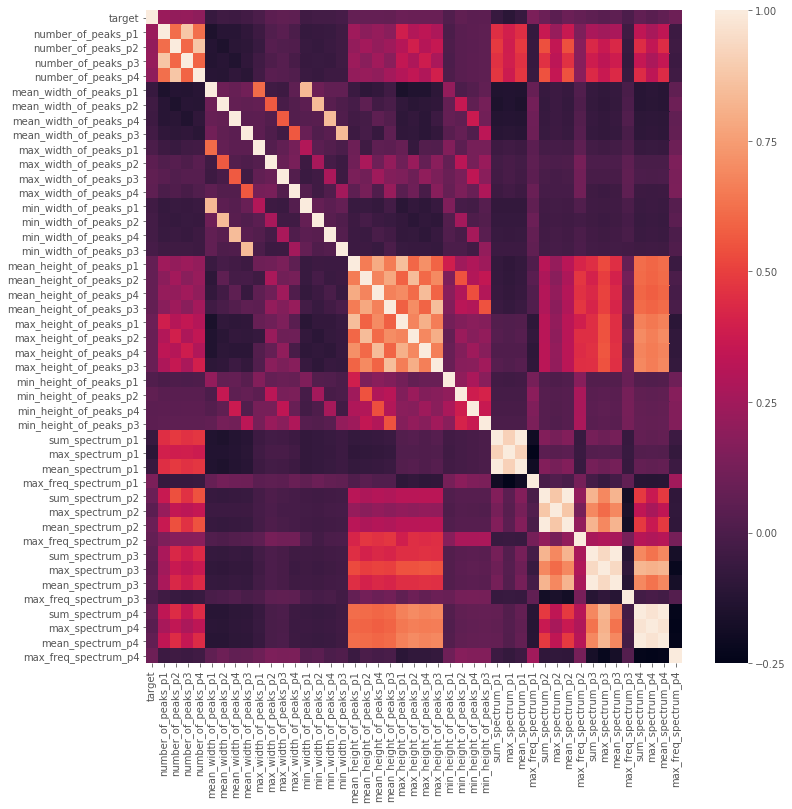

In [79]:
fig = plt.figure(figsize = (12,12))
sns.heatmap(features_norm.corr())
plt.savefig(report_dir + '/ds_heatmap.png')

In [98]:
import plotly.plotly as py
import plotly.figure_factory as ff
import plotly 

plotly.tools.set_credentials_file(username='victorspruela', api_key='QsriLXOL5rTdL3vnzeda')